[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/royforestano/Deep_Learning_Symmetries/blob/main/Deep_Learning_Symmetries_and_Their_Lie_Groups_Algebras_Subalgebras_from_First_Principles/sym_tutorial.ipynb)

# Deep Learning Symmetries and Their Lie Groups, Algebras, and Subalgebras from First Principles - Tutorial

Author: Roy Forestano

Date of Completion: 13 January 2023

Connected to the paper on: Deep Learning Symmetries and Their Lie Groups, Algebras, and Subalgebras from First Principles (arXiv:2301.05638: https://arxiv.org/abs/2301.05638)

In this notebook, I build a neural network which takes in a random state of matrices and structure constants and alters them to reproduce the generators and structure constants of a given non-abelian group [ here SO(3) ] with dimension $N$ given a data set of the same dimension. The model takes in an array of the desired number of generators $N_{g}$ as $N \times N$ matrices and an array of the structure constants with shape $N_{brackets} \times N_{g}$. One part of the model then loops over each of the generators applying a sequential layer to each. The second part is one sequential layer over the structure constant array. The model modifies these arrays to produce the desired generators and structure constants with an interconnected loss function between generators and structure constants to satisy the necessary conditions.

Aside: This notebook only computes the structure constants for $N < 6$ due to runtime issues. It will still run as desired for higher than five dimensions, but will only be finding the generators and not the structure constants. This model runs more efficiently with less epochs for lower dimensions, however, if you would like to scale the model to find the structure constants for higher dimesnions, construct a module list for the structure constants (as is being done for the generators) in the model, which will find the structure constants row by row rather than the entire matrix all at once. The number of epochs will need to be increased to arrive at the same loss, but fortunately, the model will run for large dimensions.

## Useful resources

1. Torch.norm: https://pytorch.org/docs/stable/generated/torch.norm.html
2. Rot in 4D: https://en.wikipedia.org/wiki/Rotations_in_4-dimensional_Euclidean_space
3. Matrix Norm: https://en.wikipedia.org/wiki/Matrix_norm
4. Stack lie: https://math.stackexchange.com/questions/1284164/structure-constants-for-and-the-adjoint-representation-and-meaning-in-sl2-f?rq=1
5. $L^2$ Norm: https://mathworld.wolfram.com/L2-Norm.html
6. Parameters: https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac
7. Another way to transpose, (tensor).T or torch.t(): https://pytorch.org/docs/stable/generated/torch.t.html
8. Complex Eigenvalues: https://math.stackexchange.com/questions/1546104/complex-eigenvalues-of-a-rotation-matrix

In [1]:
# !pip install torch

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import scipy
import os
import copy
from tqdm import tqdm
from time import time

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
torch.set_default_dtype(torch.float64)

In [3]:
plt.rcParams["font.family"] = 'sans-serif'
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) 

## Fix Random State

In [4]:
np.random.seed(0)
torch.manual_seed(0)

## Choose dimensions

In [5]:
n       = 300 # sample size
n_dim   = 3   # dimension
n_gen   = 3   # n_gen_full = int(n_dim*(n_dim-1)/2) formula for full algebra

## Create Data

In [6]:
# Ceate n number of n-dim vectors
data    = torch.tensor(np.random.randn(n,n_dim))

In [7]:
data.shape

torch.Size([300, 3])

## Define the possible oracles, $\phi(x)$, to be used in the loss function

In [158]:
# if n_dim==2:
def oracle_squeeze(data):
    return (data[:,0]*data[:,1]).reshape(data.shape[0],1)

def oracle_piecewise_linear(data):
#     a = data[:,0]
#     b = -data[:,1]
    return torch.where(data[:,0] >= 0, data[:,0], -data[:,1])

def oracle_manhattan(data):
    return torch.abs(data[:,0])+torch.abs(data[:,1])

def oracle_norm(data): # L^2 Norm (includes imaginary) on X: sqrt(sum(|x_i|^2))
    return torch.norm(data,dim=1)
                
if n_dim==4:
    def oracle_lorentz(data):
        return (data[:,0].reshape(data.shape[0],1))**2 \
                - (data[:,1].reshape(data.shape[0],1))**2 \
                - (data[:,2].reshape(data.shape[0],1))**2 \
                - (data[:,3].reshape(data.shape[0],1))**2  
#- torch.sum( (data[:,1:].reshape(data.shape[0],3))**2,dim=1) does not work

## Choose an oracle and epsilon $\epsilon$ for the loss function

In [9]:
oracle = oracle_norm
eps   = 1e-3
# this y is not used below
y = oracle(data)
print(y.shape)
print(y[:6])

torch.Size([300])
tensor([2.0567, 3.0764, 0.9676, 1.5180, 0.8894, 1.5446])


## Define a Lie Bracket (or Commutator)

In [10]:
def bracket(M,N):
    return M@N - N@M

## Create Initial Structure Constant Matrix to be Altered into the Structure Constants for each Unique Non-Trivial Bracket

In [11]:
n_com = int(n_gen*(n_gen-1)/2) # N_g choose 2 of these
initialize_struc_const = torch.tensor(np.random.randn(n_com,n_gen))

In [12]:
initialize_struc_const.shape

torch.Size([3, 3])

## Choose Device

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Create Model

In [14]:
# Define model
class find_generators(nn.Module):
    def __init__(self,n_dim,n_gen,n_com):
        super(find_generators,self).__init__() 
       
        G = [ nn.Linear(in_features = n_dim, out_features = n_dim, bias = False) for _ in range(n_gen)]
        
        self.gens = nn.ModuleList(G)
        
        C = [ nn.Sequential( nn.Linear(in_features = n_gen, out_features = n_gen, bias = True),
                         nn.ReLU(),
                         nn.Linear(in_features = n_gen, out_features = n_gen, bias = True),
                         nn.ReLU(),
                         nn.Linear(in_features = n_gen, out_features = n_gen, bias = True) ) for _ in range(n_com) ]

        self.struct_const = nn.ModuleList(C)
        
        self.n_gen = n_gen
        self.n_dim = n_dim
        self.n_com = n_com

    def forward(self, c, include_sc):
        
        generators = [ gen[:,:] for gen in self.gens.parameters() ]

        structure_constants = torch.zeros((self.n_com,self.n_gen))
            
        if include_sc:
            structure_constants = torch.empty((self.n_com,self.n_gen))
            for i in range(self.n_com):
                structure_constants[i,:] = ( self.struct_const[i](c[i].flatten()) ).reshape(1,self.n_gen)
        
        return structure_constants, generators

In [15]:
model = find_generators(n_dim,n_gen,n_com).to(device)
#print(model)

In [16]:
# for param in model.parameters():
#     print(type(param),param.size())

## Optimize Model Parameters

There are three components to the loss function. Note $|G| = n_{gen}$.

 1. ${\bf Invariance }$
 $$\mathcal{L}_{inv} = \frac{a_{inv}}{ \epsilon^2} \sum_{j=1}^{n_{gen}} \left\{ \sum_{i=1}^{N} \left[ \phi \left[ (I+\epsilon W_j) \vec{x}_i \right] - \phi\left(\vec{x}_i \right) \right]^2 \right\}$$
where we will use $\phi \equiv torch.norm$ here ($L^2$ norm which includes imaginary numbers), i.e.,
$$ \phi(\vec{x}) = \sqrt{\sum_{i=1}^{n_{dim}} |x_i|^2}$$


 2. ${\bf Normalization}$
 $$\mathcal{L}_{norm} = a_{norm}  \sum_{i=1}^{n_{gen}} \left[\text{Tr}(W_i W_i^T) - 2\right]^2$$
 Note that  $\text{Tr}(W_i W_i^T)$ is equivalent to squaring all the elements of an array, or performing numpy multiplication of arrays in python.
 
 
 3. ${\bf Orthogonality}$
 $$\mathcal{L}_{orth} = a_{orth}  \sum_{i, j = 1, i<j}^{n_{gen}} \text{Tr}(W_i W_j^T)^2$$ 

4. ${ \bf Closure}$
 $$\mathcal{L}_{clos} = a_{clos}  \sum_{i, j = 1, i<j}^{n_{gen}} \text{Tr}(C_{[ij]} C_{[ij]}^T)^2$$
 where
 $$C_{[ij]} = [W_i, W_j] - \sum_{k=1}^{n_{gen}} a_{[ij]k} W_k$$

and therefore, our loss becomes 
$$\mathcal{L} = \mathcal{L}_{inv} + \mathcal{L}_{norm} + \mathcal{L}_{orth} + \mathcal{L}_{clos}$$

## Define loss function and choose optimizer

In [17]:
def loss_fn(data,generators,struc_const,eps,ainv=1,anorm=1,aorth=1,aclos=1,include_sc=True):
    
    lossi = 0.
    lossn = 0.
    losso = 0.
    lossc = 0.
    comm_index = 0
    
    for i, G in enumerate(generators): 
        transform = torch.transpose((torch.eye(G.shape[0]) + eps*G)@torch.transpose(data,dim0=1,dim1=0), dim0=1,dim1=0 )
        transform = transform.reshape(data.shape[0],data.shape[1])
        
        lossi  += torch.mean( ( oracle(transform) - oracle(data) )**2 ) / eps**2 
        lossn  += (torch.sum(G**2) - 2)**2
        
        for j, H in enumerate(generators):
            if i < j:
                losso += torch.sum(G*H)**2
                
                if include_sc:
                    C1 = bracket(G,H)
                    C2 = 0
                    for k,K in enumerate(generators):
                        C2 += struc_const[comm_index,k]*K
                    C = C1 - C2
                    lossc += torch.sum(C**2)**2
                    comm_index +=1

    components= [ ainv*lossi,  anorm*lossn,  aorth*losso,  aclos*lossc ]

    L = ainv*lossi + anorm*lossn + aorth*losso + aclos*lossc 
    return  L, components

In [18]:
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Define Training Function

In [19]:
def train(initial_struc_const, 
          data, 
          model, 
          loss_fn, 
          epochs, 
          optimizer, 
          eps,
          include_sc):
    
    history = {'train_loss': [],
               'components_loss':[]} 
    
    start = time()
    
    ainv = 1.
    anorm = 1.
    aorth = 1.
    aclos = 0.
    if include_sc:
        aclos = 1.
        
    Y = initial_struc_const
    
    for i in range(epochs):
        train_loss = 0.
        model.train()
        struc_const, gens = model(Y, include_sc)
        
        loss, comp_loss = loss_fn( data         = data,
                        generators   = gens,
                        struc_const  = struc_const,
                        eps          = eps,
                        ainv         = ainv,
                        anorm        = anorm,
                        aorth        = aorth,
                        aclos        = aclos,
                        include_sc   = include_sc)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        comp_loss_for_epoch = []
        
        for j in range(len(comp_loss)):
            if torch.is_tensor(comp_loss[j]):
                comp_loss_for_epoch.append(comp_loss[j].data.item())
            else:
                comp_loss_for_epoch.append(comp_loss[j])
            
        history['train_loss'].append(train_loss)
        history['components_loss'].append(comp_loss_for_epoch)
        
        if i%100==0:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")#,end='\r') #{train_loss:>8f}
        if i==epochs-1:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")
    
        if train_loss*1e25 < 1:
            print()
            print('Reached Near Machine Zero')
            break
    
    end = time()
    total_time = end-start
    print(f'Total Time: {total_time:>.8f}')
    print("Complete.")
    return {'history': history}

## Train the Model

In [20]:
epochs =5000
include_sc = True
training = train( initial_struc_const = initialize_struc_const,
                  data                = data,
                  model               = model, 
                  loss_fn             = loss_fn,
                  epochs              = epochs,
                  optimizer           = optimizer,
                  eps                 = eps,
                  include_sc          = include_sc)

Epoch 1   |  Train Loss: 7.367966140804606
Epoch 101   |  Train Loss: 4.905572917179534
Epoch 201   |  Train Loss: 3.0495450462962723
Epoch 301   |  Train Loss: 2.1776012727782006
Epoch 401   |  Train Loss: 1.780649544308567
Epoch 501   |  Train Loss: 1.5907073302348664
Epoch 601   |  Train Loss: 1.4692577158734244
Epoch 701   |  Train Loss: 1.369144677773144
Epoch 801   |  Train Loss: 1.2694726675565393
Epoch 901   |  Train Loss: 1.1512492321187453
Epoch 1001   |  Train Loss: 0.9996713295735875
Epoch 1101   |  Train Loss: 0.8220582300841691
Epoch 1201   |  Train Loss: 0.6461147165796765
Epoch 1301   |  Train Loss: 0.4890940780093097
Epoch 1401   |  Train Loss: 0.35369716752427827
Epoch 1501   |  Train Loss: 0.24025074870457347
Epoch 1601   |  Train Loss: 0.15227109459351065
Epoch 1701   |  Train Loss: 0.09031615594570473
Epoch 1801   |  Train Loss: 0.05050260939805495
Epoch 1901   |  Train Loss: 0.026837256550635038
Epoch 2001   |  Train Loss: 0.013656648425430405
Epoch 2101   |  Trai

## Visualize the History of Training Loss

In [21]:
if n_gen>1:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.array(training['history']['components_loss'])
else:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.empty( ( train_loss.shape[0],len(training['history']['components_loss']) ) )
    for i,comp in enumerate(training['history']['components_loss']):
        for j,term in enumerate(comp):
            if torch.is_tensor(term) and term.requires_grad:
                comp_loss[i,j] = term.detach().numpy()
            else:
                comp_loss[i,j] = term

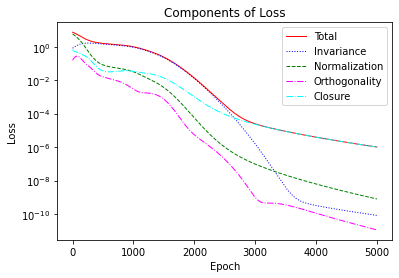

In [22]:
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot( train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.plot(comp_loss[:N,0], linewidth=1, linestyle=':',  color='b',   label='Invariance')
plt.plot(comp_loss[:N,1], linewidth=1, linestyle='--', color='g',   label='Normalization')
plt.plot(comp_loss[:N,2], linewidth=1, linestyle='-.', color='magenta', label='Orthogonality')
plt.plot(comp_loss[:N,3], linewidth=1, linestyle='-.', color='cyan', label='Closure')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Components of Loss')

plt.show()

## Extract Results

In [23]:
model.eval()

with torch.no_grad():
    struc_pred, gens_pred = model(initialize_struc_const, include_sc)

# Visualize Results

## Create a Symmetry Vector Plot (for $n_{dim} = 2$)

In [24]:
if n_dim<3:
    def draw_vectors(M, oracle):
        plt.figure(figsize=(4,3.25))   #, dpi=100)

        # Makes the background contour:
        x_grid, y_grid = np.meshgrid(np.linspace(-2,2,101), np.linspace(-2,2,101))
   
        grid_points = torch.tensor(np.stack([x_grid.flatten(), y_grid.flatten()], axis=1))
        oracle_vals = oracle(grid_points).numpy().reshape(x_grid.shape)

        plt.contourf(x_grid, y_grid, oracle_vals, 32, cmap='RdBu') #, norm = mpl.colors.CenteredNorm() )

        # now make the vector field:
        # This makes the points which are the tails of the vectors
        x_grid, y_grid = np.meshgrid(np.linspace(-2,2,20), np.linspace(-2,2,20))

        # calculates the vector at each point
        x_vec_grid, y_vec_grid = np.einsum('il,ljk', M.detach().numpy(), np.stack([x_grid, y_grid]))
       
        # loops over those points and corresponding vectors and draws the arrow
        for x, y, dx, dy in zip(x_grid.flatten(),
                                y_grid.flatten(),
                                x_vec_grid.flatten(),
                                y_vec_grid.flatten()):
       
            # this is the factor by which all vectors are scaled down:
            scale=.05
            plt.arrow(x, y, dx*scale, dy*scale, head_width=.03, lw=.5, fc='k', ec='k')

        plt.xlim(-2,2)
        plt.ylim(-2,2)
        plt.yticks(np.arange(-2,3))
        plt.xlabel('$x^{(1)}$',fontsize=12)
        plt.ylabel('$x^{(2)}$',fontsize=12)
        plt.colorbar(label='$\phi(\\vec{x})$')

In [25]:
# get the matrix of the generator you want to draw:
if n_dim<3:
    M = gens_pred[0]
    # pass that matrix into the function along with the oracle function:
    draw_vectors(M, oracle = oracle)

## View the Resulting Generator(s)

Generator 1: 
 tensor([[-3.9140e-04, -4.4344e-01,  7.6866e-01],
        [ 4.4309e-01, -2.0788e-04,  4.6117e-01],
        [-7.6887e-01, -4.6083e-01, -3.9835e-04]], requires_grad=True) 

Generator 2: 
 tensor([[-3.3961e-04, -5.2427e-01, -6.3964e-01],
        [ 5.2462e-01, -2.9813e-04,  5.6198e-01],
        [ 6.3934e-01, -5.6230e-01, -3.6104e-04]], requires_grad=True) 

Generator 3: 
 tensor([[-2.6478e-04, -7.2696e-01, -7.1632e-03],
        [ 7.2695e-01, -4.9677e-04, -6.8664e-01],
        [ 7.6516e-03,  6.8663e-01, -2.3819e-04]], requires_grad=True) 



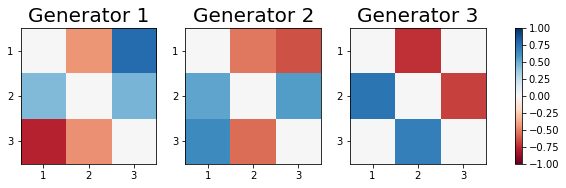

In [26]:
rows=1
cols=3
figsize=(12,2.5)

# Create labels for matrix rows and columns
ticks_gen_im =[]
ticks_gen_im_label = []
for i in range(n_dim):
    ticks_gen_im.append(i)
    ticks_gen_im_label.append(str(i+1))
    
if rows==1 and cols==1:
    fig = plt.subplots(rows,cols,figsize=figsize)
    GEN = gens_pred[0]
    plt.subplot(111)
    print(f'Generator: \n {GEN} \n')
    im = plt.imshow(GEN.detach().numpy(), cmap='RdBu', vmin=-1., vmax=1.)#norm=mpl.colors.CenteredNorm())
#     det = np.linalg.det(np.eye(GEN.shape[0]) + eps * GEN.detach().numpy())
#     ax.set_title(f'det = {det}')
#     ax.axis('off')
    plt.xticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
    plt.yticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
    plt.title('Generator '+str(1),fontsize=20)
    plt.colorbar(im)

elif n_dim==10:
    fig,axes = plt.subplots(rows,cols,figsize=figsize)
    for i,GEN in enumerate(gens_pred):
        plt.subplot(rows,cols,i+1)
        im = plt.imshow(GEN.detach().numpy(), cmap='RdBu')
        plt.axis('off')
    
else:
    fig,axes = plt.subplots(rows,cols,figsize=figsize)
#     for i, ax_GEN in enumerate(zip(axes.flat,gens_pred)):
#         plt.subplot(rows,cols,i+1)
#         if n_gen<5:
#             print(f'Generator {i+1}: \n {ax_GEN[1]} \n')
#         im = ax_GEN[0].imshow(ax_GEN[1].detach().numpy(), cmap='RdBu', vmin=-1., vmax=1.)
#         ax_GEN[0].set_xticks(ticks=ticks_gen_im)
#         ax_GEN[0].set_xticklabels(labels=ticks_gen_im_label)
#         ax_GEN[0].set_yticks(ticks=ticks_gen_im)
#         ax_GEN[0].set_yticklabels(labels=ticks_gen_im_label)
#         ax_GEN[0].set_title('Generator '+str(i+1),fontsize=20)
    for i,GEN in enumerate(gens_pred):
        plt.subplot(rows,cols,i+1)
        if n_gen<10:
            print(f'Generator {i+1}: \n {GEN} \n')
        im = plt.imshow(GEN.detach().numpy(), cmap='RdBu', vmin=-1., vmax=1.) # use ax_GEN[0] with axes
#         if n_gen<7:
#             det = np.linalg.det(np.eye(GEN.shape[0]) + eps * GEN.detach().numpy()) #ax_GEN[1]
#             plt.title(f'det = {det}')
#         plt.axis('off')
        plt.xticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
        plt.yticks(ticks=ticks_gen_im, labels=ticks_gen_im_label)
        plt.title('Generator '+str(i+1),fontsize=20)

    plt.subplots_adjust(right=0.8)
    plt.colorbar(im, ax=axes.ravel().tolist(), ticks = [-1.0,-0.75,-0.50,-0.25,0,0.25,0.50,0.75,1.0])
#plt.savefig('Orth_gen_3_3_00.png',bbox_inches='tight')

## Visualize Rotation Axis Results for  $n_{dim} = 3$, $n_{gen} = 3$

In [27]:
# Adapted from code by Alex Roman
def draw_vec(ax, v, lw, color, label):
    # Draw a vector to ax, this adds lines for the projection
    # Draw vector (0,0,0) to (v0,v1,v2)
    ax.plot([0,   v[0]], [0,   v[1]], [0, v[2]], color=color, lw=lw, label=label)
    # Fix (x,y) and draw a line from z=0 to z=v[2] (z component of rot vec)
    # Draw vector (v0,v1,0) to (v0,v1,v2) == straight line up... etc.
    ax.plot([v[0],v[0]], [v[1],v[1]], [0,v[2]], color='b', alpha=.25, ls='--')
    # Fix (x,z) and draw a line from y=0 to y=v[1] (y component of rot vec)
    ax.plot([v[0],v[0]], [0   ,v[1]], [0,0   ], color='b', alpha=.25, ls='--')
    # Fix (y,z) and draw a line from x=0 to x=v[0] (x component of rot vec)
    ax.plot([0   ,v[0]], [v[1],v[1]], [0,0   ], color='b', alpha=.25, ls='--')
    
def get_axis_np(M):
    # Finds the eigenvector with min(Imaginary(eigenvalue))
    # if the matrix is a rotation matrix or a generator of rotations, then this vector is the axis of rotation 
    eig_vals, eig_vecs = np.linalg.eig(M)
    index = np.argmin(np.sum(np.abs(eig_vecs.T.imag),axis=1)) # T is for transpose
    # find the minimum arg of the minimum imaginary component
    # pass that to the transposed eigenvector array to pull the eigenvecto
    axis = eig_vecs.T[index].real
    # Change to more positive than negative values in axis vector by multiplying by the net sign
    return np.sign(np.sum(axis))*axis

def draw_axes(gens, verbose=True):
    G1, G2, G3 = gens
    # gather rotation axes
    axis1 = get_axis_np(G1.detach().numpy())
    axis2 = get_axis_np(G2.detach().numpy())
    axis3 = get_axis_np(G3.detach().numpy())
    
    # to be more verbose (include extra detail) list the 
    # rotation axes found from the axis function
    if verbose:
        print(f'Axis 1: {axis1}')
        print(f'Axis 2: {axis2}')
        print(f'Axis 3: {axis3}')
    
    # set up plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    
    # draw x,y,z axes on graph
    ax_lim = 1
    ax.plot([-ax_lim,ax_lim],[0,0],[0,0], color='black', alpha=.3)
    ax.plot([0,0],[-ax_lim,ax_lim],[0,0], color='black', alpha=.3)
    ax.plot([0,0],[0,0],[-ax_lim,ax_lim], color='black', alpha=.3)

    # set bounds on graph to be +-1
    ax.set_xlim(-ax_lim,ax_lim)
    ax.set_ylim(-ax_lim,ax_lim)
    ax.set_zlim(-ax_lim,ax_lim)
    
    # draw each rotation axis
    lw = 5
    draw_vec(ax = ax, v = axis1, lw=lw, color = 'b', label='Axis '+str(1))
    draw_vec(ax = ax, v = axis2, lw=lw, color = 'r', label='Axis '+str(2))
    draw_vec(ax = ax, v = axis3, lw=lw, color = 'g', label='Axis '+str(3))
    plt.legend()
    plt.show()

Axis 1: [-0.460997 0.768762 0.443267]
Axis 2: [0.562144 0.639494 -0.524444]
Axis 3: [0.686640 -0.007407 0.726960]


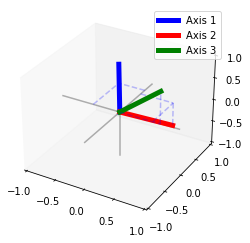

In [28]:
if len(gens_pred)==3 and n_dim==3:
    draw_axes(gens_pred)
    plt.show()

## View the Resulting Structure Constants (for $n_{gen}>1$)

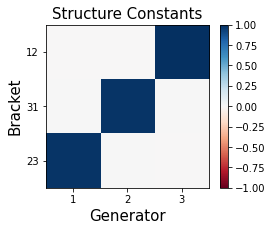

In [29]:
if n_gen>1:
    
    figsize=(4,3)
    
    if n_gen==3:
        X = torch.tensor(struc_pred.numpy())
        struc_cyclic = X
        struc_cyclic[1] = -X[1]
        
    commutator_labels = []
    if n_com==3:
        # Make the commutations cyclic for 3 generators
        for i in range(n_gen):
             for j in range(n_gen):
                    if i<j:
                        if (j-i)==2:
                            commutator_labels.append(str(j+1)+str(i+1))
                        else:
                            commutator_labels.append(str(i+1)+str(j+1))
    else:
        for i in range(n_gen):
            for j in range(n_gen):
                if i<j:
                    commutator_labels.append(str(i+1)+str(j+1))
        
    ticks_com = []
    for i in range(n_com):
        ticks_com.append(i)

    ticks_gen = []
    generator_labels = []
    for i in range(n_gen):
        ticks_gen.append(i)
        generator_labels.append(str(i+1))
    
    plt.figure(figsize=figsize)
    if n_com==3:
        plt.imshow(struc_cyclic.detach().numpy(), cmap='RdBu', vmin=-1.,vmax=1.)#norm=mpl.colors.CenteredNorm())
    else:
        plt.imshow(struc_pred.detach().numpy(), cmap='RdBu', vmin=-1.,vmax=1.)#norm=mpl.colors.CenteredNorm())
    plt.xticks(ticks=ticks_gen,labels=generator_labels)
    plt.xlabel('Generator',fontsize=15)
    plt.yticks(ticks=ticks_com,labels=commutator_labels)
    plt.ylabel('Bracket',fontsize=15)
    plt.title('Structure Constants',fontsize=15)
    plt.colorbar()
    plt.savefig('Orth_sc_3_3_00.png',bbox_inches='tight')
    
#     # add grid lines
#     for i in range(n_gen-1):
#         plt.axvline(x=1/2+i, linewidth=1, color ='black')
#     for i in range(n_com-1):
#         plt.axhline(y=1/2+i-0.01, linewidth=1, color ='black')

# Verify Results

## Verify the Structure Constants Produce an Algebra (for $n_{gen}>1$)

In [30]:
if n_gen>1:
    if n_gen==3:
        X = torch.tensor(struc_pred.numpy())
        struc_cyclic = X
        struc_cyclic[1] = -X[1]

    comm_index = 0
    Cs = []
    for i,G in enumerate(gens_pred):
        for j,H in enumerate(gens_pred):
            if i<j and n_gen!=3:
                C1 = bracket(G,H)
                C2 = 0
                for k,K in enumerate(gens_pred):
                    C2 += struc_pred[comm_index,k]*K
                C = C1 - C2
                error = torch.mean(torch.abs(C.real))
                print(str(i+1)+str(j+1)+': \n Structure Constants = '+str(struc_pred[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                print(f'The structure constants were found with a mean absolute error (MAE) of {error}. \n \n')
                Cs.append(C)
                comm_index+=1
            # Make the cyclic commutators if n_gen = 3   
            elif i<j and n_gen==3:
                if (j-i)==2:
                    C1 = bracket(H,G)
                    C2 = 0
                    for k,K in enumerate(gens_pred):
                        C2 += struc_cyclic[comm_index,k]*K
                    C = C1 - C2
                    error = torch.mean(torch.abs(C.real))
                    print(str(j+1)+str(i+1)+': \n Structure Constants = '+str(struc_cyclic[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                    print(f'The structure constants were found with a mean absolute error (MAE) of {error}. \n \n') 
                    Cs.append(C)
                    comm_index+=1
                else:
                    C1 = bracket(G,H)
                    C2 = 0
                    for k,K in enumerate(gens_pred):
                        C2 += struc_cyclic[comm_index,k]*K
                    C = C1 - C2
                    error = torch.mean(torch.abs(C.real))
                    print(str(i+1)+str(j+1)+': \n Structure Constants = '+str(struc_cyclic[comm_index,:].detach().numpy())+'\n \n C = \n ',C.detach().numpy(),'\n')
                    print(f'The structure constants were found with a mean absolute error (MAE) of {error}. \n \n') 
                    Cs.append(C)
                    comm_index+=1
    
    
    # Calculate the total MSE in finding the structure constants
    tot_error = 0.
    for i,C in enumerate(Cs):
        tot_error+=torch.mean(torch.abs(C.real))
    print(f'Total MAE = {tot_error}')
    # if error < 1e-1:
    #     print(f'The structure constants were found successfully with a mean absolute error (MAE) of {error}.')
    # else:
    #     print(f'The structure constants were NOT found successfully with a mean absolute error (MAE) of {error}.')

12: 
 Structure Constants = [-0.000073 -0.000008 1.000093]
 
 C = 
  [[-0.000436 0.000078 -0.000233]
 [0.000026 0.000496 0.000143]
 [-0.000335 -0.000053 0.000940]] 

The structure constants were found with a mean absolute error (MAE) of 0.000304416209479401. 
 

31: 
 Structure Constants = [0.002750 0.983181 0.000000]
 
 C = 
  [[0.000213 -0.008051 -0.012984]
 [0.007151 -0.000188 0.008171]
 [0.012748 -0.008201 0.000960]] 

The structure constants were found with a mean absolute error (MAE) of 0.0065185870757251095. 
 

23: 
 Structure Constants = [0.979646 0.000151 -0.000134]
 
 C = 
  [[0.000327 -0.008679 0.015581]
 [0.009395 -0.000281 0.009373]
 [-0.015887 -0.009031 0.000931]] 

The structure constants were found with a mean absolute error (MAE) of 0.007720492825243068. 
 

Total MAE = 0.014543496110447578


## Verify Orthogonality (for $n_{gen}>1$)

In [31]:
def get_angle(v, w):
    # Angle between vectors
    return v @ w / (torch.norm(v) * torch.norm(w))

def get_axis(M):
    # Finds the eigenvector with min(Imaginary(eigenvalue))
    # if the matrix is a rotation matrix or a generator of rotation,s then this vector is the axis of rotation  
    eig_vals, eig_vecs = torch.linalg.eig(M)
    # find the minimum arg of the minimum imaginary component
    # pass that to the transposed eigenvector array to pull the eigenvector
    axis = eig_vecs.T[torch.argmin(torch.abs(eig_vals.imag))]
    # Change to more positive than negative values in axis vector by multiplying by the net sign
    return torch.sign(torch.sum(axis).real)*axis

In [32]:
for i,G in enumerate(gens_pred):
    for j,H in enumerate(gens_pred):
        if i<j:
            angle = get_angle(get_axis(G).real, get_axis(H).real)
            angle_deg = 180/np.pi*np.arccos(float(get_angle(get_axis(G).real, get_axis(H).real)))
            print(f'Angle between generator {i+1} and {j+1}: {angle:>.10f} rad, {angle_deg:>.10f} deg')

Angle between generator 1 and 2: 0.0000026493 rad, 89.9998482079 deg
Angle between generator 1 and 3: 0.0000043556 rad, 89.9997504430 deg
Angle between generator 2 and 3: 0.0000039597 rad, 89.9997731272 deg


---
# Discontinuous Oracle Examples

## Create Non-Linear Model

In [109]:
# Define model
class find_nonlinear_generators(nn.Module):
    def __init__(self,n_dim,n_gen):
        super(find_nonlinear_generators,self).__init__() 
       
        G = [ nn.Sequential( nn.Linear(in_features = n_dim, out_features = n_dim**2, bias = True),
                              nn.ReLU(),
                              nn.Linear(in_features = n_dim**2, out_features = n_dim**2, bias = True),
                              nn.ReLU(),
                              nn.Linear(in_features = n_dim**2, out_features = n_dim**2, bias = True),
                              nn.ReLU(),
                              nn.Linear(in_features = n_dim**2, out_features = n_dim, bias = True) ) for _ in range(n_gen) ]
        
        self.gens = nn.ModuleList(G)
        
        self.n_gen = n_gen
        self.n_dim = n_dim

    def forward(self, data, eps):
        transformed_data = [ self.gens[i](data)[:,:] for i in range(self.n_gen) ]
        #data + eps*self.gens[i](data)
        return transformed_data

## Optimize Model Parameters

Define loss function and choose optimizer

In [110]:
def loss_fn_nonlinear(data,
                      transformed_data,
                      eps,
                      ainv=1.,
                      anorm=1.,
                      aorth=1.):
    
    lossi = 0.
    lossn = 0.
    losso = 0.
    
    for i, T1 in enumerate(transformed_data): 
        lossi  += torch.mean( ( oracle(T1) - oracle(data) )**2 ) / eps**2 
#         lossn  += torch.mean( ((T1-data).abs().norm(dim=1) - eps)**2 ) / eps**2
        
#         lossn  += ( torch.mean( torch.sum((data-T1)*(data-T1).conj(), dim=1).abs().sqrt() ) - eps*6)**2 
#         mean = torch.mean( ( torch.sum(T1*T1.conj(), dim=1).abs().sqrt() )**2 )
#         lossn  += torch.mean( ( torch.sum(T1*T1.conj(), dim=1).abs().sqrt() - mean)**2 )
#         lossn += torch.sum((data-T1)*(data-T1).conj(), dim=1).abs().sqrt().std()**2
        
#         for j, T2 in enumerate(transformed_data):
#             if i < j:
#                 t1norm = torch.sum((data-T1)*(data-T1).conj(), dim=1).abs().sqrt()
#                 t2norm = torch.sum((data-T2)*(data-T2).conj(), dim=1).abs().sqrt()
#                 t1t2dot = torch.sum((data-T1)*(data-T2).conj(), dim=1).abs()

#                 losso += torch.sum( (t1t2dot/t1norm/t2norm)**2 )

    components = [ ainv*lossi,  anorm*lossn,  aorth*losso ]

    L = ainv*lossi + anorm*lossn + aorth*losso
    return  L, components

## Define Training Function

In [111]:
def train_nonlinear(data, model, loss_fn, epochs, optimizer, eps):
    
    history = {'train_loss': [],
               'components_loss':[]} 
    start = time()
    best_val_loss = torch.inf
    ainv = 1.
    anorm = 1.
    aorth = 1.
    
    X = data.to(device)
    
    for i in range(epochs):
        train_loss = 0.
        model.train()
        transformed_data = model(X, eps)
        
        loss, comp_loss = loss_fn(data         = X,
                                  transformed_data = transformed_data,
                                  eps          = eps,
                                  ainv         = ainv,
                                  anorm        = anorm,
                                  aorth        = aorth )

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        comp_loss_for_epoch = []
        
        for j in range(len(comp_loss)):
            if torch.is_tensor(comp_loss[j]):
                comp_loss_for_epoch.append(comp_loss[j].data.item())
            else:
                comp_loss_for_epoch.append(comp_loss[j])
            
        history['train_loss'].append(train_loss)
        history['components_loss'].append(comp_loss_for_epoch)
        
        if i%1000==0:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")#,end='\r') #{train_loss:>8f}
        if i==epochs-1:
            print(f"Epoch {i+1}   |  Train Loss: {train_loss}")
            
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model = copy.deepcopy(model)
#             torch.save(model.state_dict(),'best_complex_U6.pth') 
    
        if train_loss*1e25 < 1:
            print()
            print('Reached Near Machine Zero')
            break
            
    model = best_model 
    end = time()
    total_time = end-start
    print(f'Total Time: {total_time:>.8f}')
    print("Complete.")
    return {'history': history}

## Choose dimensions

In [173]:
np.random.seed(1)
torch.manual_seed(1)
n       = 300 # sample size
n_dim   = 2   # dimension
n_gen   = 1   # n_gen_full = int(n_dim*(n_dim-1)/2) formula for full algebra
data    = torch.tensor(np.random.randn(n,n_dim))
oracle = oracle_piecewise_linear #oracle_manhattan
eps   = 1e-3
lr  = 1e-3
model_nonlinear = find_nonlinear_generators(n_dim,n_gen).to(device)
optimizer = torch.optim.Adam(model_nonlinear.parameters(), lr=lr)

In [174]:
# oracle_squeeze
# oracle_piecewise_linear
# oracle_manhattan

## Train the Model

In [175]:
epochs =20000

training = train_nonlinear( data                = data,
                            model               = model_nonlinear, 
                            loss_fn             = loss_fn_nonlinear,
                            epochs              = epochs,
                            optimizer           = optimizer,
                            eps                 = eps)

Epoch 1   |  Train Loss: 1051824.3286825358
Epoch 1001   |  Train Loss: 130336.14411626819
Epoch 2001   |  Train Loss: 80617.8430102243
Epoch 3001   |  Train Loss: 17506.269884146892
Epoch 4001   |  Train Loss: 11317.013525453773
Epoch 5001   |  Train Loss: 9968.005254588497
Epoch 6001   |  Train Loss: 9560.734206361532
Epoch 7001   |  Train Loss: 7974.9853856808195
Epoch 8001   |  Train Loss: 1781.7362947847164
Epoch 9001   |  Train Loss: 184.84439950363952
Epoch 10001   |  Train Loss: 40.01229050441213
Epoch 11001   |  Train Loss: 76.20948442014267
Epoch 12001   |  Train Loss: 8.640725050170683
Epoch 13001   |  Train Loss: 4.044379517106008
Epoch 14001   |  Train Loss: 2.006799964500681
Epoch 15001   |  Train Loss: 1.1139811635686547
Epoch 16001   |  Train Loss: 0.6305495040666029
Epoch 17001   |  Train Loss: 1.820857570179966
Epoch 18001   |  Train Loss: 1.1339457281504526
Epoch 19001   |  Train Loss: 2.593722233960448
Epoch 20000   |  Train Loss: 0.17593901718809693
Total Time: 36.

## Visualize the History of Training Loss

In [176]:
if n_gen>1:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.array(training['history']['components_loss'])
else:
    train_loss = np.array(training['history']['train_loss'])
    comp_loss = np.empty( ( train_loss.shape[0],len(training['history']['components_loss']) ) )
    for i,comp in enumerate(training['history']['components_loss']):
        for j,term in enumerate(comp):
            if torch.is_tensor(term) and term.requires_grad:
                comp_loss[i,j] = term.detach().numpy()
            else:
                comp_loss[i,j] = term

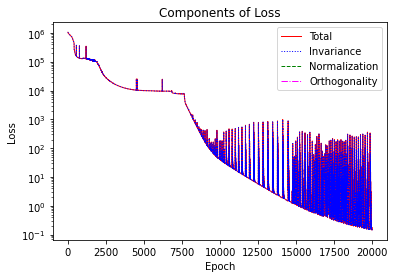

In [177]:
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot( train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.plot(comp_loss[:N,0], linewidth=1, linestyle=':',  color='b',   label='Invariance')
plt.plot(comp_loss[:N,1], linewidth=1, linestyle='--', color='g',   label='Normalization')
plt.plot(comp_loss[:N,2], linewidth=1, linestyle='-.', color='magenta', label='Orthogonality')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Components of Loss')

plt.show()

## Extract Results

In [178]:
model_nonlinear.eval()

with torch.no_grad():
    transformed_data = model_nonlinear(data,eps)

# Visualize Results

## Create a Symmetry Vector Plot (for $n_{dim} = 2$)

In [179]:
if n_dim<3:
    def draw_vectors_nonlinear(model, oracle):
        plt.figure(figsize=(4,3.25))   #, dpi=100)

        # Makes the background contour:
        x_grid, y_grid = np.meshgrid(np.linspace(-2,2,101), np.linspace(-2,2,101))
        grid_points = torch.tensor(np.stack([x_grid.flatten(), y_grid.flatten()], axis=1))
        oracle_vals = oracle(grid_points).numpy().reshape(x_grid.shape)
        plt.contourf(x_grid, y_grid, oracle_vals, 32, cmap='RdBu') #, norm = mpl.colors.CenteredNorm() )

        # now make the vector field:
        # This makes the points which are the tails of the vectors
        x_grid, y_grid = np.meshgrid(np.linspace(-2,2,20), np.linspace(-2,2,20))
        # these are the initial coordinates of the grid points to be transformed
        initial_grid_points =  torch.tensor(np.stack([x_grid.flatten(), y_grid.flatten()], axis=1))

        # calculates the vector at each point
        model.eval()
        with torch.no_grad():
            new_grid_points = model(initial_grid_points,eps)[0].detach().numpy()-initial_grid_points.numpy()

        x_vec_grid, y_vec_grid = (new_grid_points[:,0].reshape(x_grid.shape),new_grid_points[:,1].reshape(y_grid.shape) )
       
        # loops over those points and corresponding vectors and draws the arrow
        for x, y, dx, dy in zip(x_grid.flatten(),
                                y_grid.flatten(),
                                x_vec_grid.flatten(),
                                y_vec_grid.flatten()):
       
            # this is the factor by which all vectors are scaled down:
            scale=0.05
            plt.arrow(x, y, dx*scale, dy*scale, head_width=.03, lw=.5, fc='k', ec='k')

        plt.xlim(-2,2)
        plt.ylim(-2,2)
        plt.yticks(np.arange(-2,3))
        plt.xlabel('$x^{(1)}$',fontsize=12)
        plt.ylabel('$x^{(2)}$',fontsize=12)
        plt.colorbar(label='$\phi(\\vec{x})$')

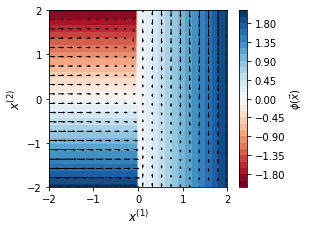

In [180]:
# get the matrix of the generator you want to draw:
if n_dim<3:
    # pass that matrix into the function along with the oracle function:
    draw_vectors_nonlinear(model = model_nonlinear, oracle = oracle)